# Google Merch Shop Website EDA ＆ AFM analysis by k-means
## 簡介
此份分析主要是針對Google Merch Shop 的2016九月的網站做成效分析及應用AFM做客戶分群，並提供分析結論。資料來源：https://www.kaggle.com/datasets/bigquery/google-analytics-sample/data
## 分析步驟
### Step1:Define the problem
### Step2:Data wrangling
### Step3:Exploration data analysis
### Step4:AFM analysis applied by K-means method
### Step5:Insight,Summary and Next step

## Step1: Define the problem
### Promblem:
- 1. 網站九月份的使用情形？
- 2. 網站客群的輪廓？
#### Promblem breakdown:
1. 網站九月份的使用情形？ 
- 九月份每日的訪問量（sessions）有什麼變化？
- Average Session Duration,是否存在短時停留（<10 秒）的高比例？
2. 網站客群的輪廓？
- 哪些國家或城市的訪問量最高？不同地區的轉化率差異？
- 主要流量來源?哪個來源的流量轉化率最高？
- 手機 vs 桌面 vs 平板流量佔比？哪個裝置的轉化率最高？
- AFM分析（k-means）

## Step2: Data Wrangling

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
!pip install google-cloud-bigquery pandas


In [7]:
pip install db-dtypes


Note: you may need to restart the kernel to use updated packages.


In [8]:
from google.cloud import bigquery
import pandas as pd
import os

#金鑰檔案的實際路徑
key_file_path = "/Users/smt/Documents/Code/DS/website_traffic/gen-lang-client-0249061651-fc2b60448fe9.json"

# 設定環境變數
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = key_file_path
# 創建 BigQuery 客戶端。這會自動使用 GOOGLE_APPLICATION_CREDENTIALS 環境變數中的金鑰檔案。
client = bigquery.Client()

# 定義要查詢的資料表 ID
table_id = "bigquery-public-data.google_analytics_sample.ga_sessions_20170801"

# 構建 SQL 查詢

query = """
    SELECT *
    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE _TABLE_SUFFIX BETWEEN '20160901' AND '20160930'
    ;
"""

# 執行查詢並將結果儲存到 DataFrame
try:
    query_job = client.query(query)
    # 將查詢結果轉換為 Pandas DataFrame
    df = query_job.to_dataframe()

    print("資料成功下載並轉換為 DataFrame！")
    print(df.head())

except Exception as e:
    print(f"發生錯誤: {e}")

資料成功下載並轉換為 DataFrame！
   visitorId  visitNumber     visitId  visitStartTime      date  \
0       <NA>            5  1473815616      1473815616  20160913   
1       <NA>            3  1473186877      1473186877  20160906   
2       <NA>            2  1473214674      1473214674  20160906   
3       <NA>           13  1473195039      1473195039  20160906   
4       <NA>            1  1472854833      1472854833  20160902   

                                              totals  \
0  {'visits': 1, 'hits': 84, 'pageviews': 60, 'ti...   
1  {'visits': 1, 'hits': 52, 'pageviews': 34, 'ti...   
2  {'visits': 1, 'hits': 90, 'pageviews': 66, 'ti...   
3  {'visits': 1, 'hits': 165, 'pageviews': 115, '...   
4  {'visits': 1, 'hits': 12, 'pageviews': 8, 'tim...   

                                       trafficSource  \
0  {'referralPath': None, 'campaign': '(not set)'...   
1  {'referralPath': None, 'campaign': 'AW - Dynam...   
2  {'referralPath': '/', 'campaign': '(not set)',...   
3  {'referralP

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71032 entries, 0 to 71031
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   visitorId             0 non-null      Int64 
 1   visitNumber           71032 non-null  Int64 
 2   visitId               71032 non-null  Int64 
 3   visitStartTime        71032 non-null  Int64 
 4   date                  71032 non-null  object
 5   totals                71032 non-null  object
 6   trafficSource         71032 non-null  object
 7   device                71032 non-null  object
 8   geoNetwork            71032 non-null  object
 9   customDimensions      71032 non-null  object
 10  hits                  71032 non-null  object
 11  fullVisitorId         71032 non-null  object
 12  userId                0 non-null      object
 13  clientId              0 non-null      object
 14  channelGrouping       71032 non-null  object
 15  socialEngagementType  71032 non-null

In [ ]:
df.isnull().any()
df1 = df.drop(columns=['visitId','visitorId','userId','clientId','visitStartTime','totals','trafficSource','device','geoNetwork','customDimensions','hits'], axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71032 entries, 0 to 71031
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   visitNumber           71032 non-null  Int64 
 1   date                  71032 non-null  object
 2   fullVisitorId         71032 non-null  object
 3   channelGrouping       71032 non-null  object
 4   socialEngagementType  71032 non-null  object
dtypes: Int64(1), object(4)
memory usage: 2.8+ MB


In [13]:
# visit,hits,bounces,transactions,totalTransactionRevenue,subContinent,country,timeOnSite,deviceCategory
df1['totalsVisits'] = df['totals'].apply(lambda x: x.get('visits'))
df1['totalsHits'] = df['totals'].apply(lambda x: x.get('hits'))
df1['totalsBounces'] = df['totals'].apply(lambda x: x.get('bounces'))
df1['totalsTransactions'] = df['totals'].apply(lambda x: x.get('transactions'))
df1['totalsTransactionRevenue'] = df['totals'].apply(lambda x: x.get('totalTransactionRevenue'))
df1['totalsTimeOnSite'] = df['totals'].apply(lambda x: x.get('timeOnSite'))
df1['subContinent'] = df['geoNetwork'].apply(lambda x: x.get('subContinent'))
df1['country'] = df['geoNetwork'].apply(lambda x: x.get('country'))
df1['device'] = df['device'].apply(lambda x: x.get('deviceCategory'))


df1.iloc[0]

visitNumber                                    5
date                                    20160913
fullVisitorId                2287637838474850444
channelGrouping                           Direct
socialEngagementType        Not Socially Engaged
totalsVisits                                   1
totalsHits                                    84
totalsBounces                                NaN
totalsTransactions                           1.0
totalsTransactionRevenue             328200000.0
totalsTimeOnSite                          1367.0
subContinent                    Northern America
country                            United States
device                                   desktop
Name: 0, dtype: object

In [14]:
df1['date']= pd.to_datetime(df1['date'])
df1['date']

0       2016-09-13
1       2016-09-06
2       2016-09-06
3       2016-09-06
4       2016-09-02
           ...    
71027   2016-09-08
71028   2016-09-16
71029   2016-09-16
71030   2016-09-12
71031   2016-09-26
Name: date, Length: 71032, dtype: datetime64[ns]

In [15]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71032 entries, 0 to 71031
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   visitNumber               71032 non-null  Int64         
 1   date                      71032 non-null  datetime64[ns]
 2   fullVisitorId             71032 non-null  object        
 3   channelGrouping           71032 non-null  object        
 4   socialEngagementType      71032 non-null  object        
 5   totalsVisits              71032 non-null  int64         
 6   totalsHits                71032 non-null  int64         
 7   totalsBounces             34808 non-null  float64       
 8   totalsTransactions        870 non-null    float64       
 9   totalsTransactionRevenue  859 non-null    float64       
 10  totalsTimeOnSite          36131 non-null  float64       
 11  subContinent              71032 non-null  object        
 12  country           

## Step3: Exploration Data Analysis

Text(0.5, 1.0, 'daily_traffic')

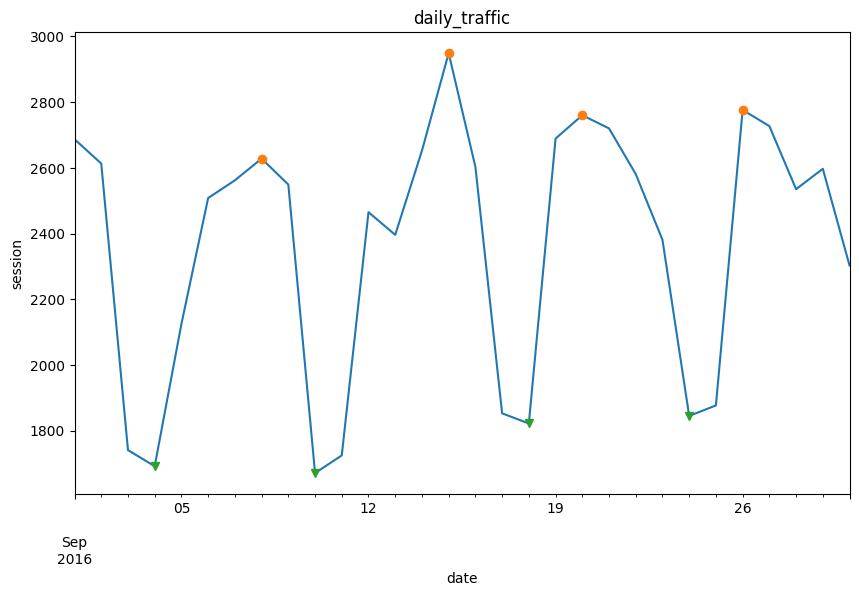

In [21]:
from scipy.signal import find_peaks

daily_traffic=df1.groupby('date').size() #session
peaks,_ = find_peaks(daily_traffic,distance=5)
lows, _ = find_peaks(-daily_traffic,distance=5)
daily_traffic.plot(figsize = (10,6))
plt.plot(daily_traffic.index[peaks],daily_traffic.iloc[peaks],'o')
plt.plot(daily_traffic.index[lows],daily_traffic.iloc[lows],'v')
plt.ylabel('session')
plt.title('daily_traffic')




In [ ]:
peaks_w = pd.Series(['2016-09-08','2016-09-15','2016-09-20','2016-09-26'])
PW= pd.to_datetime(peaks_w).dt.dayofweek
lows_w = pd.Series(['2016-09-04','2016-09-10','2016-09-18','2016-09-24'])
LW = pd.to_datetime(lows_w).dt.dayofweek
print(PW,LW)

0    3
1    3
2    1
3    0
dtype: int32 0    6
1    5
2    6
3    5
dtype: int32


Insight:週末的流量偏低？推測主要訪客是基於活動或企業採購，因此才會於平日時段造訪此網站

Average Session Duration is  281.0 (in seconds)
Short term visit proportion: 0.39


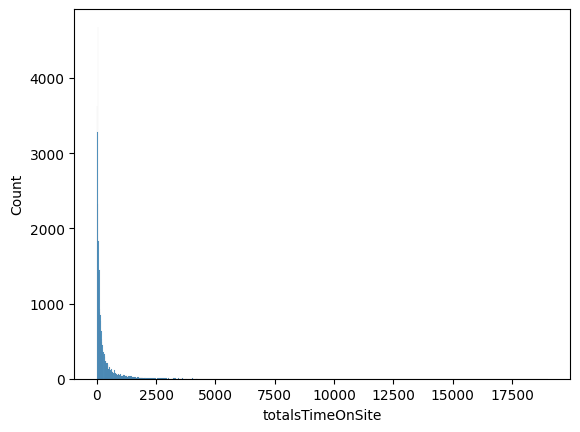

In [48]:
# Average Session Duration多少？是否存在短時停留（<10 秒）的高比例？
ASD=df1['totalsTimeOnSite'].mean()
sns.histplot(df1['totalsTimeOnSite'])
lowSession=df1[df1['totalsTimeOnSite']<10].size / df1['totalsTimeOnSite'].size
print('Average Session Duration is ',round(ASD,1),'(in seconds)')
print('Short term visit proportion:',round(lowSession,2))


Insight:平均停留時間約四分鐘，短暫停留比例約4成

country
United States    0.031235
Puerto Rico      0.021277
Portugal         0.007407
Hong Kong        0.005391
South Africa     0.005076
Chile            0.004739
Canada           0.004475
Singapore        0.004464
South Korea      0.002865
Saudi Arabia     0.002817
dtype: float64

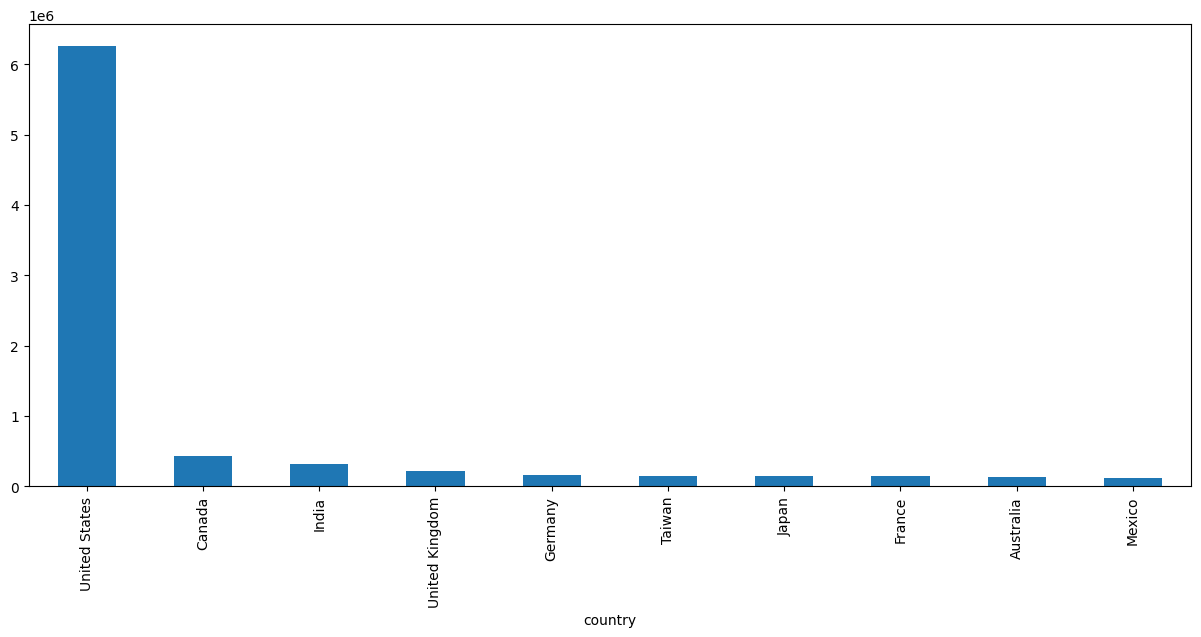

In [24]:
# By country
CS=df1.groupby('country')['totalsTimeOnSite'].sum().nlargest(10)
CS.plot(kind='bar',figsize=(15,6))
# CR:total transaction/ total session
CCR = df1.groupby('country')['totalsTransactions'].sum() / df1.groupby('country').size()
CCR.nlargest(10)

Insight:主要訪客是來自於USA，USA的轉換率也是所有國家中最高，值得注意的是Canada、India、UK，這幾個訪問量較低，但轉換率好的國家

channelGrouping
(Other)           0.000000
Affiliates        0.000000
Direct            0.016378
Display           0.026442
Organic Search    0.010298
Paid Search       0.022026
Referral          0.054192
Social            0.000283
dtype: float64

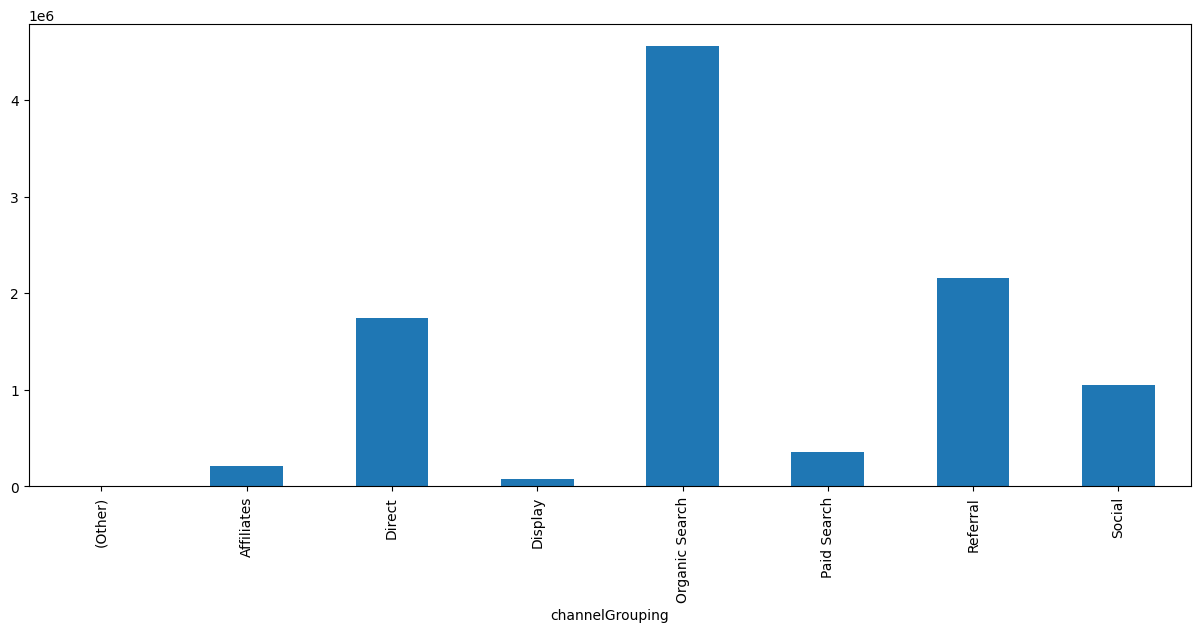

In [25]:
# by channelGrouping
CGS=df1.groupby('channelGrouping')['totalsTimeOnSite'].sum()
CGS.plot(kind='bar',figsize=(15,6))
# CR:total transaction/ total session
CGCR = df1.groupby('channelGrouping')['totalsTransactions'].sum() / df1.groupby('channelGrouping').size()
CGCR

Insight:Organic Search（自然搜尋）和 Social（社群媒體）的數值偏低，這可能意味著網站的內容行銷（SEO）或社群媒體經營還有很大的成長空間。值得注意的是Display、Paid Search廣告的轉換率並不好

device
desktop    0.014756
mobile     0.004336
tablet     0.005058
dtype: float64

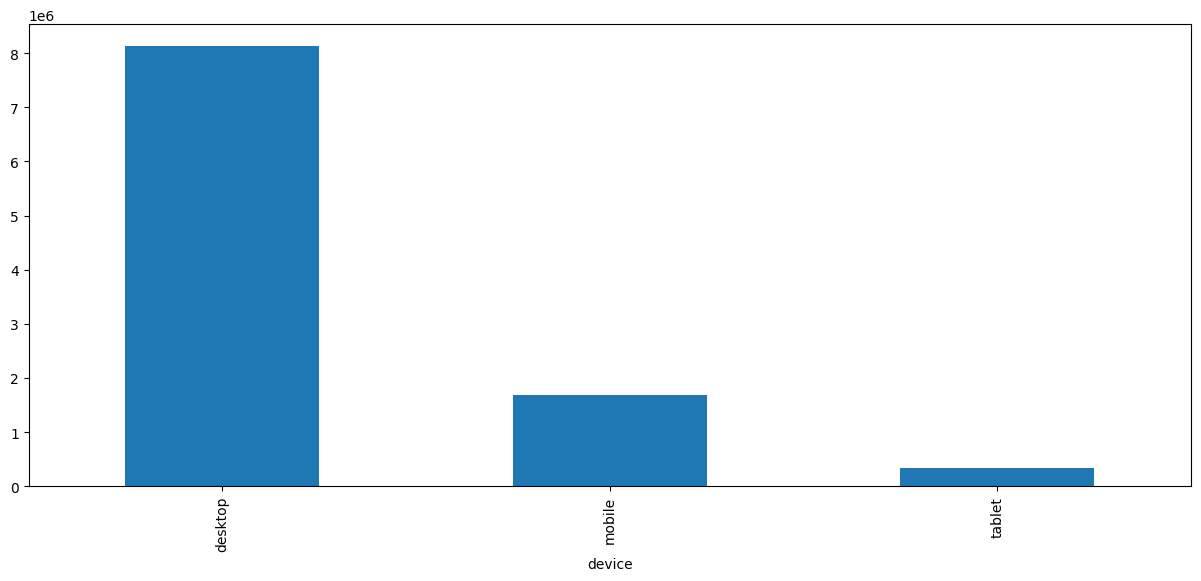

In [26]:
# by device
DS=df1.groupby('device')['totalsTimeOnSite'].sum()
DS.plot(kind='bar',figsize=(15,6))
# CR:total transaction/ total session
DCR = df1.groupby('device')['totalsTransactions'].sum() / df1.groupby('device').size()
DCR

Insight:大部分的人都是桌電，可以應證訪客很可能大部分都是因活動或企業採購用途

## Step4: AFM analysis applied by K-means method
有別於常見的RFM，這次分群方法使用AFM(Activity-Frequency-Monetary)，原因是這次使用的是九月的資料，Recency的維度會比較不適合應用在僅有單月的資料上，所以使用RFM的變形AFM。

In [129]:
AFM = df1.groupby('fullVisitorId').agg({
    'totalsHits':'sum',
    'totalsVisits':'sum',
    'totalsTransactionRevenue':'sum'
}).reset_index()
AFM.columns=['ID','Activity','Frequency','Monetary']
AFM = AFM[AFM['Monetary']>0]
AFM['Monetary'] = AFM['Monetary']/(10**6)
AFM

,ID,Activity,Frequency,Monetary
122,0020502892485275044,162,1,5.77
129,0021939395292136520,107,1,35.95
157,0026203741366904270,105,5,298.07
188,0032288790526152703,9,1,28.99
209,0036417634769000138,48,2,34.48
...,...,...,...,...
58884,9964156711625932045,27,1,11.56
58895,9965495974379156538,30,1,30.30
58942,9975702176622548240,110,4,42.74
59024,9988272152672987767,80,1,36.96


In [130]:
Q1 = AFM['Monetary'].quantile(0.25)
Q3 = AFM['Monetary'].quantile(0.75)
IQR = Q3 - Q1
AFM = AFM[~(AFM['Monetary'] < (Q1 - 1.5 * IQR)) | (AFM['Monetary'] > (Q3 + 1.5 * IQR))]
AFM

,ID,Activity,Frequency,Monetary
122,0020502892485275044,162,1,5.77
129,0021939395292136520,107,1,35.95
157,0026203741366904270,105,5,298.07
188,0032288790526152703,9,1,28.99
209,0036417634769000138,48,2,34.48
...,...,...,...,...
58884,9964156711625932045,27,1,11.56
58895,9965495974379156538,30,1,30.30
58942,9975702176622548240,110,4,42.74
59024,9988272152672987767,80,1,36.96


In [131]:
#標準化
from sklearn.preprocessing import StandardScaler

AFM_scaled = StandardScaler().fit_transform(AFM[['Activity','Frequency','Monetary']])
print(AFM_scaled)

[[ 1.44027256 -0.45543957 -0.26434344]
 [ 0.57972735 -0.45543957 -0.21680465]
 [ 0.5484348   0.57084803  0.19608038]
 ...
 [ 0.62666618  0.31427613 -0.2061092 ]
 [ 0.15727788 -0.45543957 -0.21521372]
 [-0.6563285  -0.45543957 -0.23485616]]


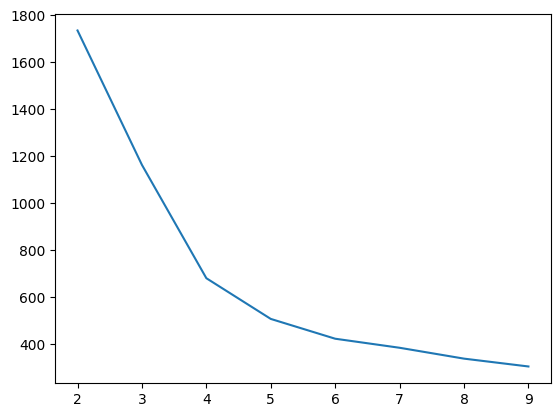

In [137]:
# elbow method 決定適合的k
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
WCSS=[]

for k in range(2,10):
    km = KMeans(n_clusters=k,random_state=42)
    km.fit(AFM_scaled) #用資料去訓練模型
    WCSS.append(km.inertia_) #km.inertia_ 是ＷＣＳＳ的值

plt.plot(range(2,10),WCSS)





In [133]:
# kmeans

kmeans = KMeans(n_clusters=4, random_state=42)
AFM["Cluster"] = kmeans.fit_predict(AFM_scaled)

In [134]:
AFMC= AFM.groupby("Cluster")[["Activity","Frequency","Monetary"]].mean()
AFMC

,Activity,Frequency,Monetary
Cluster,,,
0,191.179775,6.707865,332.457528
1,136.000000,1.000000,16032.750000
2,757.000000,86.000000,25.930000
3,53.363506,2.155172,130.699239


In [135]:
AFM.groupby("Cluster")[["Activity","Frequency","Monetary"]].count()

,Activity,Frequency,Monetary
Cluster,,,
0,89,89,89
1,1,1,1
2,1,1,1
3,696,696,696


- Cluster 0：高價值、中度瀏覽的沉睡客戶
- Cluster 1：一次性超高價值的低瀏覽客戶
- Cluster 2：將流失的高瀏覽量忠實訪客
- Cluster 3：極具潛力的新進高瀏覽客戶

## Step5:Insight,Summary and Next step

## Insight:
- 週末的流量偏低？推測主要訪客是基於活動或企業採購，因此才會於平日時段造訪此網站
- 平均停留時間約四分鐘，短暫停留比例約4成
- 主要訪客是來自於USA，USA的轉換率也是所有國家中最高，值得注意的是Canada、India、UK，這幾個訪問量較低，但轉換率好的國家
- Organic Search（自然搜尋）和 Social（社群媒體）的數值偏低，這可能意味著網站的內容行銷（SEO）或社群媒體經營還有很大的成長空間。值得注意的是Display、Paid Search廣告的轉換率並不好
- 大部分的人都是桌電，可以應證訪客很可能大部分都是因活動或企業採購用途
- 客戶可以簡單分為
    - Cluster 0：高價值、中度瀏覽的沉睡客戶
    - Cluster 1：一次性超高價值的低瀏覽客戶
    - Cluster 2：將流失的高瀏覽量忠實訪客
    - Cluster 3：極具潛力的新進高瀏覽客戶
## Summary:
- 網站流量在九月呈現週期性的變化，普遍平日流量比週末來的高，推斷是主要訪客是基於企業活動或採購，因此才會於平日時段造訪。
- 主要訪客來自USA，可以注意潛在消費力的國家（Canada、India、UK）。
- 在廣告面要特別注意廣告投放的表現，以及行銷面要留意社群媒體上的行銷。
- 可以針對分群結果採取不同的手段。
## Next Step:
- 針對不同地區優化廣告投放的策略
- 拉出主要造訪的企業，可以根據分群結果，對不同客戶推出方案
    - Cluster 0：高價值、中度瀏覽的沉睡客戶 >> 花費偏高但活動度一般，可以利用綑綁優惠及活動，讓客戶看到更多商品
    - Cluster 1：一次性超高價值的低瀏覽客戶 >> 超級VIP客戶，客戶知道自己需要什麼，可以推出固定合作方案
    - Cluster 2：將流失的高瀏覽量忠實訪客 >> 此類客戶活動度較高，但花費偏低，可以請業務特別了解客戶需求
    - Cluster 3：極具潛力的新進高瀏覽客戶 >> 屬於潛在客戶，有一般的花費但活動度偏低，可以推出優惠方案刺激消費